# **Information Retrieval system using an on-disk inverted index implementation**

In this work, we will develop an **on-disk** indexing and information retrieval system, as computational constraints prevent keeping the entire index in memory. To build the index, we will use the **SPIMI (Single-Pass In-Memory Indexing) algorithm**, which processes documents in *chunks* that are later merged together. This approach avoids memory overflow issues, while maintaining an efficient creation phase.

Once the inverted index is generated, we will evaluate the search engine’s performance using **BM25** and **TF-IDF**. For each model, we will implement both the **Document-At-A-Time** (DAAT) and **Term-At-A-Time** (TAAT) approaches, in order to compare not only ranking quality but also the efficiency of postings list access strategies. Finally, we will compare our results with those from **PyTerrier**, to assess the strengths and limitations of our prototype.

For experimentation, we will use **MS MARCO Passage Ranking** and **TREC-DL 2020**, which provide queries, documents, and relevance judgments necessary for our goals.


## 1. **Setup & Dependencies**

### 1.1 **Package Installation**

In [ ]:
!pip install ir_datasets -q
!pip install nltk -q
!pip install ir_measures -q
!pip install PyStemmer -q
!pip install pandas -q
!pip install pympler -q
!pip install zstandard -q
!pip install python-terrier -q
!pip install gdown -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.9/731.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.5/167.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


### 1.2 **Library Imports**

In [ ]:
import gc
import gzip
import heapq
import math
import os
import pickle
import random
import re
import shutil
import string
import time
import unicodedata
from collections import Counter, defaultdict, OrderedDict
from functools import lru_cache
from glob import glob
from urllib.parse import urlparse
import matplotlib.pyplot as plt

import ir_datasets
import ir_measures
from ir_measures import *
import msgpack
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pyterrier as pt
import Stemmer
import zstandard as zstd
from google.colab import drive
from pympler import asizeof
from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize

import mmap
import bisect

In [ ]:
def profile(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        ms = (end - start) * 1000
        print(f"{f.__name__} ({ms:.3f} ms)")
        return result
    return f_timer

### 1.3 **Data Loading**


In [ ]:
dataset = ir_datasets.load("msmarco-passage")

drive.mount('/content/drive')

# URL of the Google Drive repository containing the project files
repository = "https://drive.google.com/drive/folders/19fafX8ac4-OTdnmKUvqCe_LbbKKGJAFW"
repository_name = "inverted_index"

#Download the specified folder from the repository
!gdown --folder $repository

#Copy the downloaded files from the repository folder to /content/
#This ensures the files are easily accessible during execution
for item in os.listdir(repository_name):
  s = os.path.join(repository_name, item)
  d = os.path.join('/content/', item)
  if os.path.isfile(s):
    shutil.copy2(s, d)
  print(s)

# Remove the downloaded repository folder to free up space
shutil.rmtree(repository_name)

# Unmount Google Drive
drive.flush_and_unmount()

Mounted at /content/drive
Retrieving folder contents
Processing file 1iQlisO-AoQ1oLFQ8CU0lgUq1FKxsDlVT stats.pkl.zst
Processing file 1wEzjundwN0N_4srgjQvLlSmZYe7rlz6Y doc_index.pkl.zst
Processing file 1EaxH6GjqvH0n5hx-o1Z4D6Xjk8sgaUK7 merged_index.msgpack
Processing file 1CV7poD--F2eXJUCyrBn5rk7XJWUv2gS9 lexicon_with_offsets.pkl.zst
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1iQlisO-AoQ1oLFQ8CU0lgUq1FKxsDlVT
To: /content/inverted_index/stats.pkl.zst
100% 98.0/98.0 [00:00<00:00, 462kB/s]
Downloading...
From: https://drive.google.com/uc?id=1wEzjundwN0N_4srgjQvLlSmZYe7rlz6Y
To: /content/inverted_index/doc_index.pkl.zst
100% 8.49M/8.49M [00:00<00:00, 21.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1EaxH6GjqvH0n5hx-o1Z4D6Xjk8sgaUK7
From (redirected): https://drive.google.com/uc?id=1EaxH6GjqvH0n5hx-o1Z4D6Xjk8sgaUK7&confirm=t&uuid=f0533ed0-f380-490a-b56d-8

## 2. **Preprocessing**

### 2.1 **Normalization & Tokenization**

1. **Casefold & Unicode normalization**  
   - Lowercase conversion  
   - Replace *&* with *and*  
   - Normalize quotes and dashes  

2. **Acronym & dash handling**  
   - Remove dots in acronyms  
   - Replace intra-word dashes with spaces  

3. **URL expansion**: extracting domain and path tokens from them.

4. **Tokenization**

5. **Filtering & normalization**  
   - Discard tokens made only of punctuation/symbols  
   - Unicode normalize each token  
   - Remove NLTK English stopwords  

6. **Stemming**, using Snowball stemmer, an improvement of Porter stemmer.

In [ ]:
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)

# ---  global precompilations ---
STEMMER = Stemmer.Stemmer("english")
STOPWORDS = set(stopwords.words("english"))
ACRONYM_RE = re.compile(r"\.(?!(\S[^. ])|\d)")
URL_RE = re.compile(r"(?:https?://)?(?:www\.)?[a-z0-9\-]+\.[a-z]{2,}(?:/[^\s]*)?", re.IGNORECASE)
QUOTE_DASH_TRANS = str.maketrans("‘’´“”–—-", "'''\"\"---")
DASH = re.compile(r"(?<=\w)-(?=\w)")
# ------------------------------

def url_to_tokens(u: str) -> str:
    """
    Converts a URL string into useful tokens: domain and split path components.
    Args:
        u (str): The URL to tokenize.
    Returns:
        str: Space-separated tokens extracted from the URL.
    """
    if not u.startswith(("http://", "https://")):
        u = "http://" + u
    p = urlparse(u)
    parts = p.netloc.split(".") + re.split(r"[\/\-_\.]", p.path)
    return " ".join(t for t in parts if t)

def preprocess(text: str) -> list[str]:
    """
    Preprocess input text.
    Args:
        text (str): The input text to preprocess.
    Returns:
        list[str]: List of processed tokens.
    """
    text = text.lower().replace("&", " and ").translate(QUOTE_DASH_TRANS)

    text = ACRONYM_RE.sub("", text)

    text = DASH.sub(" ", text)

    text = URL_RE.sub(lambda m: " " + url_to_tokens(m.group(0)) + " ", text)

    tokens = word_tokenize(text)

    tokens = [
        unicodedata.normalize("NFKC", t)
        for t in tokens
        if any(c.isalnum() for c in t)
    ]

    tokens = [t for t in tokens if t not in STOPWORDS]

    return STEMMER.stemWords(tokens)


### 2.2 **Example Application**


In [ ]:
samples = [
    "I Will Take The Ring, Though I Do Not Know The Way - F.R.O.D.O. said",
    "You were the Chosen-One—It was said that you would *destroy* the www.sith.net/prophecy, not join them!"
]

for doc in samples:
    tokens = preprocess(doc)
    print(f"Original: {doc}\nTokens:   {tokens}\n")

Original: I Will Take The Ring, Though I Do Not Know The Way - F.R.O.D.O. said
Tokens:   ['take', 'ring', 'though', 'know', 'way', 'frodo', 'said']

Original: You were the Chosen-One—It was said that you would *destroy* the www.sith.net/prophecy, not join them!
Tokens:   ['chosen', 'one', 'said', 'would', 'destroy', 'www', 'sith', 'net', 'propheci', 'join']



---

## 3. **On-Disk Inverted Index** (SPIMI + Merge)


### 3.1 **Configurable Parameters**

In [ ]:
MAX_POSTINGS_IN_RAM = 8_000_000
CHUNK_SIZE          = 2_000_000
BATCHES             = 50_000
TEMP_DIR_NAME       = "temp_postings"
COMPRESSOR          = zstd.ZstdCompressor(level=10)
DECOMPRESSOR        = zstd.ZstdDecompressor()

### 3.2 **Building SPIMI Chunks**

We index the corpus in one pass, periodically dumping in-memory postings to disk to bound RAM usage:

- **Document Index**  
  A NumPy array of document lengths (`doc_index[d]`), compressed with zstd.
  Since in the dataset there isn't any other information on the document other than the document length, we use an array instead of a dictionary.

- **Lexicon**  
  A dictionary mapping each term to `[termID, docFreq, totalTermFreq]`, assigning IDs on first occurrence.

- **Partial Postings**  
  `inv_d[termID]` and `inv_f[termID]` collect docIDs and term frequencies for up to `CHUNK_SIZE` documents.

- **Chunk Dumps**  
  After every `CHUNK_SIZE` docs:
  1. Serialize `inv_d`/`inv_f` and save to `inverted_chunk_<id>.pkl`.  
  2. Clear buffers and run GC (garbage collector).  
  3. Increment chunk id.

- **Finalisation**  
  Flush any leftover postings, then compress and save:
  - `doc_index.pkl.zst`  
  - `stats.pkl.zst` (num_docs, num_terms, num_tokens, avg_length)  
  - `lexicon.pkl.zst`

This SPIMI strategy ensures we never hold the full index in memory; later, chunks are merged into the final index with offset bookkeeping.

In [ ]:
def _save_partial_index(inv_d, inv_f, out_dir, chunk_id):
    inv_path = os.path.join(out_dir, f"inverted_chunk_{chunk_id}.pkl")
    with open(inv_path, "wb") as f:
        pickle.dump({"docids": dict(inv_d), "freqs": dict(inv_f)}, f)

@profile
def build_spimi_index(dataset, out_dir="index_chunks"):
    os.makedirs(out_dir, exist_ok=True)
    lexicon = {}
    doc_index = []
    inv_d = defaultdict(list)
    inv_f = defaultdict(list)
    termid_counter = 0
    total_tokens = 0
    chunk_id = 0

    for docid, doc in tqdm(enumerate(dataset.docs_iter()), total=dataset.docs_count(), desc="Indexing"):
        tokens = preprocess(doc.text)
        token_tf = Counter(tokens)

        for token, tf in token_tf.items():
            if token not in lexicon:
                lexicon[token] = [termid_counter, 0, 0]
                termid_counter += 1
            term_id = lexicon[token][0]
            lexicon[token][1] += 1
            lexicon[token][2] += tf
            inv_d[term_id].append(docid)
            inv_f[term_id].append(tf)

        doclen = len(tokens)
        doc_index.append(doclen)
        total_tokens += doclen

        if docid % CHUNK_SIZE == 0:
            _save_partial_index(inv_d, inv_f, out_dir, chunk_id)
            chunk_id += 1
            inv_d.clear()
            inv_f.clear()
            gc.collect()

    if inv_d:
        _save_partial_index(inv_d, inv_f, out_dir, chunk_id)
        inv_d.clear()
        inv_f.clear()

    # Compress and save document index
    doc_index = np.array(doc_index, dtype=np.uint32)
    with open("doc_index.pkl.zst", "wb") as f:
        with COMPRESSOR.stream_writer(f) as writer:
            pickle.dump(doc_index, writer)

    # Compress and save stats
    stats = {
        "num_docs": docid+1,
        "num_terms": len(lexicon),
        "num_tokens": total_tokens,
        "avg_length": total_tokens / (docid+1)
    }
    print(stats)
    with open("stats.pkl.zst", "wb") as f:
        with COMPRESSOR.stream_writer(f) as writer:
            pickle.dump(stats, writer)

    # Compress and save lexicon
    with open("lexicon.pkl.zst", "wb") as f:
        with COMPRESSOR.stream_writer(f) as writer:
            pickle.dump(lexicon, writer)

    gc.collect()


### 3.3 **Encoding & Compression Utilities**

To produce a compact, seekable final index, we apply to each posting list:

- **Delta + Variable-Byte Coding**  
  Convert sorted docIDs into gaps, then VB-encode both gaps and term frequencies into self-delimiting byte streams.

- **Zstandard Compression**  
  Package VB streams with MessagePack and compress, deferring offset calculations until after compression to ensure accurate byte offsets.

At query time, `decompress_posting_list` reverses these steps, to recover the original docID and frequency lists.

In [ ]:
# Variable byte encoding
def _vb_encode_number(n):
    bytes_ = []
    while True:
        bytes_.insert(0, n % 128)
        if n < 128:
            break
        n //= 128
    bytes_[-1] += 128
    return bytes_

def vb_encode_list(numbers):
    bytestream = []
    for n in numbers:
        bytestream.extend(_vb_encode_number(n))
    return bytestream

# Variable byte decoding
def vb_decode_list(bytestream):
    numbers = []
    n = 0
    for b in bytestream:
        if b < 128:
            n = (n << 7) + b
        else:
            n = (n << 7) + (b - 128)
            numbers.append(n)
            n = 0
    return np.array(numbers, dtype=np.int32)

# Delta encoding (need arr to be sorted)
def delta_encode(arr):
    if not arr:
        return []
    encoded = [arr[0]]
    for i in range(1, len(arr)):
        encoded.append(arr[i] - arr[i - 1])
    return encoded

# Delta decoding
def delta_decode(encoded):
    if len(encoded) == 0:
        return np.array([], dtype=np.int32)
    return np.cumsum(encoded, dtype=np.int32)

In [ ]:
def decompress_posting_list(compressed):
    decompressed = DECOMPRESSOR.decompress(compressed)
    data = msgpack.unpackb(decompressed)

    vb_docids = data["docids_vb"]
    vb_freqs = data["freqs_vb"]

    delta_docids = vb_decode_list(vb_docids)
    docids = delta_decode(delta_docids)
    freqs = vb_decode_list(vb_freqs)

    return docids.tolist(), freqs.tolist()

### 3.4 **Spill & Flush**

- **Spilling**  
  When in-RAM postings exceed `MAX_POSTINGS_IN_RAM`, one termID at a time is hashed into one of the `BATCHES` batch files, until the threshold is no longer exceeded. Each time we hash a termID we append its docID/freq lists in the corresponding batch file, and clear those entries to reclaim memory.

- **Flushing**  
  As soon as a term’s postings have been collected from all chunks containing that term:
  1. Load and merge any spilled segments.  
  2. Sort by docID.  
  3. Compress posting list
  4. Write the blob to the index file; record its byte `offset` and `length` in the lexicon. `offset` is the location in bytes  of the posting list inside the inverted index and `lenght` is the dimension in bytes of the posting list.

This scheme bounds RAM usage throughout merging while producing contiguous, compressed postings for every term.  


Helper functions:

In [ ]:
def get_temp_path(temp_dir, prefix):
    return os.path.join(temp_dir, f"batch_{prefix}.pkl")

def spill_to_temp(term_postings, total_postings, temp_dir, term_to_batch_map):
    """Spill some terms to temporary disk files to free memory."""
    spilled = 0
    batch_map = defaultdict(lambda: {"docids": {}, "freqs": {}}) # batch_prefix -> {docids -> {tid -> []}, freqs: {tid -> []}}

    print(f"Spilling terms to disk, current postings in RAM: {total_postings}")
    for tid in list(term_postings.keys()):
        prefix = tid % BATCHES
        batch_map[prefix]["docids"][tid] = term_postings[tid][0]
        batch_map[prefix]["freqs"][tid] = term_postings[tid][1]
        term_to_batch_map[tid] = prefix
        total_postings -= len(term_postings[tid][0])
        del term_postings[tid]
        spilled += 1

        if total_postings < MAX_POSTINGS_IN_RAM:
            break

    # Save batch data to temporary files
    for prefix, data in batch_map.items():
        path = get_temp_path(temp_dir, prefix)

        if os.path.exists(path):
            with open(path, "rb") as f:
                old_data = pickle.load(f)

            for tid in data["docids"]:
                old_data["docids"].setdefault(tid, []).extend(data["docids"][tid])
                old_data["freqs"].setdefault(tid, []).extend(data["freqs"][tid])

            data = old_data

        with open(path, "wb") as f:
            pickle.dump(data, f)

    print(f"\nSpilled {spilled} terms to disk.")
    return total_postings


def flush_term_to_index(term_id, term_postings, temp_dir, index_file, offset_map, term_to_batch_map):
    """Flush the complete posting list of a term to the index file."""
    # Retrieve term's temporary file, if exists
    prefix = term_to_batch_map.get(term_id)

    if prefix is not None:
        batch_path = get_temp_path(temp_dir, prefix)
        with open(batch_path, "rb") as tf:
            batch_data = pickle.load(tf)

        term_postings[term_id][0].extend(batch_data["docids"][term_id])
        term_postings[term_id][1].extend(batch_data["freqs"][term_id])

        # Update batch file
        del term_to_batch_map[term_id]
        del batch_data["docids"][term_id]
        del batch_data["freqs"][term_id]
        if batch_data["docids"]:
            with open(batch_path, "wb") as f:
                pickle.dump(batch_data, f)
        else:
            os.remove(batch_path)

    # Sort and encode posting list
    all_docids, all_freqs = term_postings[term_id]
    postings = sorted(zip(all_docids, all_freqs))
    docids_sorted, freqs_sorted = zip(*postings) if postings else ([], [])

    docids_delta = delta_encode(docids_sorted)
    vb_docids = vb_encode_list(docids_delta)
    vb_freqs = vb_encode_list(freqs_sorted)

    # Compress and save posting list
    data = msgpack.packb({
        "docids_vb": vb_docids,
        "freqs_vb": vb_freqs
    })
    compressed = COMPRESSOR.compress(data)
    offset = index_file.tell()
    index_file.write(compressed)

    # Save offset and length in a temporary structure
    offset_map[term_id] = (offset, len(compressed))

    del term_postings[term_id]


### 3.5 **Merge & Final Lexicon**

- **Initialize Counters**  
  Scan all `inverted_chunk_<i>.pkl` files to count, for each term, how many chunks contain it (`term_chunk_count`).

- **One-Pass Merge**  
  For each chunk and term:  
  1. **Append** in-RAM postings, reduce its chunk count.  
  2. **Flush** if count = 0 (merge spills, sort, encode, compress, write blob, record offset/length).  
  3. **Spill** to batch files if in-RAM postings exceed threshold.

- **Lexicon Update**  
  Load original lexicon and augment each entry with its final `(fileOffset, byteLength)`, enabling constant-time access to compressed postings.  


In [ ]:
@profile
def merge_spimi_chunks(output_index_path="merged_index.msgpack",
                       lexicon_path="lexicon.pkl.zst",
                       lexicon_path_out="lexicon_with_offsets.pkl.zst",
                       chunk_dir="index_chunks"):
    chunk_files = sorted(glob("index_chunks/inverted_chunk_*.pkl"))

    # Analyze which terms are in which chunks
    term_chunk_map = defaultdict(set) # term_id -> [chunk_indexes]
    for chunk_index, chunk_file in enumerate(tqdm(chunk_files, desc="Scanning chunks")):
        with open(chunk_file, "rb") as f:
            chunk = pickle.load(f)
            for term_id in chunk["docids"]:
                term_chunk_map[term_id].add(chunk_index)
            del chunk
            gc.collect()

    # Transform it in a dict of counters
    term_chunk_count = {term_id: len(chunks) for term_id, chunks in term_chunk_map.items()}
    del term_chunk_map
    gc.collect()

    # Load term stats (for the loading bar)
    stats_path = "stats.pkl.zst"
    with open(stats_path, "rb") as f:
        with DECOMPRESSOR.stream_reader(f) as reader:
            stats = pickle.load(reader)
    num_terms = stats["num_terms"]
    progress = tqdm(total=num_terms, desc="Terms written", unit="term")

    # Merge loop
    term_postings = defaultdict(lambda: [[], []])
    term_to_batch_map = {} # term_id -> batch_prefix
    offset_map = {} # term_id -> (offset, length)
    n_postings = 0
    os.makedirs(TEMP_DIR_NAME, exist_ok=True)

    with open(output_index_path, "wb") as index_file:
        for chunk_file in chunk_files:
            with open(chunk_file, "rb") as f:
                chunk = pickle.load(f)

            for term_id, docids in chunk["docids"].items():
                term_postings[term_id][0].extend(docids)
                term_postings[term_id][1].extend(chunk["freqs"][term_id])
                term_chunk_count[term_id] -= 1

                # flush term to index if it has been seen in all chunks
                if term_chunk_count[term_id] == 0:
                    flush_term_to_index(
                        term_id, term_postings, TEMP_DIR_NAME,
                        index_file, offset_map, term_to_batch_map
                    )
                    progress.update(1)
                # else increment postings in RAM
                else:
                    n_postings += len(docids)

            if n_postings >= MAX_POSTINGS_IN_RAM:
                n_postings = spill_to_temp(term_postings, n_postings, TEMP_DIR_NAME, term_to_batch_map)
            else:
                print("No need to spill terms to disk, memory usage is within limits.")

            del chunk
            gc.collect()

    progress.close()

    # Merge offset_map with the lexicon
    print("Updating lexicon with offsets...")
    with open(lexicon_path, "rb") as f:
        with DECOMPRESSOR.stream_reader(f) as reader:
            lexicon = pickle.load(reader)

    lexicon_with_offsets = {}
    for term, (tid, df, cf) in lexicon.items():
        off, length = offset_map.get(tid, (-1, -1))
        lexicon_with_offsets[term] = (tid, df, cf, off, length)

    with open(lexicon_path_out, "wb") as f:
        with COMPRESSOR.stream_writer(f) as writer:
            pickle.dump(lexicon_with_offsets, writer)

    print("All done!")


### 3.6 **Index loading or creation**

In [ ]:
files = ['merged_index.msgpack', 'lexicon_with_offsets.pkl.zst', 'doc_index.pkl.zst', 'stats.pkl.zst']
lex, doc, stats = None, None, None

# Check if all required files exist
if all(os.path.exists(file) for file in files):
    print("All files already exist.")

    # Iterate over the list of files and their associated variable names
    for file in files:
        if os.path.getsize(file) > 0:
            continue
        else:
            print(f"Error: {file} is empty. Rebuilding the index.")
            build_spimi_index(dataset, "index_chunks")
            merge_spimi_chunks()
            break
else:
    # If any of the files do not exist, rebuild the index
    build_spimi_index(dataset, "index_chunks")
    merge_spimi_chunks()

# Load lexicon, doc_index and stats in memory
with open("lexicon_with_offsets.pkl.zst", "rb") as f:
    with DECOMPRESSOR.stream_reader(f) as reader:
        lex = pickle.load(reader)

with open("doc_index.pkl.zst", "rb") as f:
    with DECOMPRESSOR.stream_reader(f) as reader:
        doc = pickle.load(reader)

with open("stats.pkl.zst", "rb") as f:
    with DECOMPRESSOR.stream_reader(f) as reader:
        stats = pickle.load(reader)

All files already exist.


### 3.7 **Disk-Based Inverted Index**

This implementation differs from a traditional in-RAM index in several key ways:

- **Memory-Mapped Postings File**  
  Instead of loading all posting lists into memory, we `mmap` the consolidated index file. Postings are accessed by seeking the pre-computed byte offsets and lengths, allowing OS-level paging to handle I/O transparently.

- **On-Demand Decompression**  
  Posting lists remain compressed on disk (delta + VB + Zstd). Each list is decompressed and unpacked only when first requested, minimizing upfront CPU and memory cost.

- **LRU Cache of Recent Postings**  
  To reduce decompression cost and speed up repeated queries, we maintain a small in-process cache (e.g. 1024 terms) keyed by term string.

- **Handling Out-Of-Vocabulary**
  If a query term is not in the vocabulary, its posting list will be empty.
  
This allows to reach a **minimal resident memory footprint**, since at any time, only the lexicon, statistics, document index and a bounded number of decompressed posting arrays live in memory. Large collections can thus be served on machines with limited RAM, relying on the OS and disk for the remainder.  


In [ ]:
class DiskInvertedIndex:
    """
    A simple inverted index class. Stores term-document mappings for fast retrieval.

    Attributes:
        lexicon (dict): Maps a token to [termID, docFreq, totalTermFreq].
        inv (mmap object): Contains the inverted file.
        doc (list): Each element is doc_length.
        stat (dict): Index statistics (e.g., num_docs, num_terms, num_tokens).
    """

    class PostingListIterator:
        """
        Iterates over the posting list for a single termID.

        Attributes:
            docids (list[int]): Document IDs containing this term.
            freqs (list[int]): Term frequencies in the corresponding docID.
            pos (int): Current index in the posting list.
            doc (list): Reference to the main document index.
        """

        def __init__(self, docids, freqs, doc):
            """
            Initialize the iterator with document IDs, frequencies, and a reference to the document index.
            """
            self.docids = docids            # List of document IDs where the term appears
            self.freqs = freqs              # List of term frequencies corresponding to each document ID
            self.pos = 0                    # Start position in the posting list
            self.doc = doc                  # Reference to the main document index

        def docid(self):
            """
            Returns the current document ID or math.inf if the end of the list is reached.
            """
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]

        def score(self):
            """
            Computes the term frequency normalized by the document length for the current position.
            Returns math.inf if the end of the list is reached.
            """
            if self.is_end_list():
                return math.inf
            return self.freqs[self.pos]/self.doc[self.docid()]

        def next(self, target = None):
            """
            Advances to the next position in the posting list or jumps to the target document ID.
            """
            if not target:
                if not self.is_end_list():
                    self.pos += 1
            else:
                self.pos = bisect.bisect_left(self.docids, target, self.pos)

        def is_end_list(self):
            """
            Checks if the iterator has reached the end of the posting list.
            """
            return self.pos == len(self.docids)

        def len(self):
            """
            Returns the total number of document IDs in the posting list.
            """
            return len(self.docids)

    def __init__(self, lex, postings_file, doc, stats):
        """
        Initialize the inverted index with its components: lexicon, inverted file, document index, and stats.
        """
        self.lexicon = lex          # Lexicon mapping tokens to [termID, docFreq, totalTermFreq]
        self.doc = doc              # List of documents with IDs and lengths
        self.stats = stats           # Index statistics (e.g., number of documents, terms, tokens)

        # Maps the binary file of the posting lists
        if os.path.exists(postings_file):
            with open(postings_file, "rb") as f:
                self.inv = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
        else:
            raise FileNotFoundError(f"Posting file {postings_file} does not exist")

        # Cache logic
        self.cache = OrderedDict()  # term -> PostingListIterator
        self.cache_size = 1024
        self.cache_hits = 0
        self.cache_misses = 0

    def num_docs(self):
        """
        Returns the total number of indexed documents.
        """
        return self.stats['num_docs']

    def get_posting(self, term):
        """
        Returns a PostingListIterator for the given term ID.
        """
        # Check cache first
        if term in self.cache:
            self.cache_hits += 1
            self.cache.move_to_end(term)            # Move the term to the end of the cache to mark it as recently used
            docids, freqs = self.cache[term]
        else:
            # Handle Out-Of-Vocabulary
            if term not in self.lexicon:
                print(f"Term '{term}' not found in lexicon.")
                return DiskInvertedIndex.PostingListIterator([], [], self.doc)

            self.cache_misses += 1

            offset, length = self.lexicon[term][3], self.lexicon[term][4]
            comp_posting_list = self.inv[offset:offset+length]
            docids, freqs = decompress_posting_list(comp_posting_list)

            self.cache[term] = (docids, freqs)  # Store in cache
            if len(self.cache) > self.cache_size:
                # Remove the oldest entry from the cache
                self.cache.popitem(last=False)

        return DiskInvertedIndex.PostingListIterator(docids, freqs, self.doc)

    def get_postings(self, terms):
        """
        Returns a list of PostingListIterators for the given term IDs.
        """
        return [self.get_posting(term) for term in terms]

    # Utility functions for the cache
    def print_cache_stats(self):
        """
        Prints the cache hit and miss rates.
        """
        print(f"Cache hits: {self.cache_hits}")
        print(f"Cache misses: {self.cache_misses}")
        total = self.cache_hits + self.cache_misses
        if total > 0:
            hit_rate = 100 * self.cache_hits / total
            print(f"Hit rate: {hit_rate:.2f}%")

    def reset_cache_stats(self, clear_cache=False):
        """
        Resets the cache statistics.
        If clear_cache is True, also clears the cache.
        """
        self.cache_hits = 0
        self.cache_misses = 0
        if clear_cache:
            self.cache.clear()
            gc.collect()

In [ ]:
disk_inv_index = DiskInvertedIndex(lex, "merged_index.msgpack", doc, stats)

---

## 4. **Query Processing**

We now evaluate BM25 and TF-IDF retrieval models on MS MARCO Passage and TREC-DL 2020 using two strategies:
- **DAAT (Document-At-A-Time)**: advance all term iterators in parallel, scoring one document at a time with efficient skipping and early termination.  
- **TAAT (Term-At-A-Time)**: process each term’s postings sequentially, accumulating scores per document before extracting the top results.  


In [ ]:
trec_dl_2020 = ir_datasets.load("msmarco-passage/trec-dl-2020")

### 4.1 **Helpers**

In [ ]:
class TopQueue:
    """
    A simple top-k priority queue to maintain the top-scoring items.

    This class uses a min-heap to efficiently store and retrieve the top-k
    items based on their scores. Items are tuples of (score, docid).

    Attributes:
        queue (list[tuple[float, int]]): The priority queue storing (score, docid) pairs.
        k (int): The maximum number of items to maintain in the queue.
        threshold (float): The minimum score required for an item to enter the queue.
    """

    def __init__(self, k=10, threshold=0.0):
        """
        Initializes the TopQueue with a maximum size and an optional threshold.
        """
        self.queue = []                     # Initialize an empty priority queue (min-heap)
        self.k = k                          # Maximum number of items to store
        self.threshold = threshold          # Initial score threshold

    def size(self):
        """
        Returns the current number of items in the queue.
        """
        return len(self.queue)

    def would_enter(self, score):
        """
        Checks if a given score exceeds the current threshold and could enter the queue.
        """
        return score > self.threshold

    def clear(self, new_threshold=None):
        """
        Clears all items from the queue and optionally sets a new threshold.
        """
        self.queue = []                     # Empty the queue
        if new_threshold is not None:
            self.threshold = new_threshold  # Update the threshold if provided

    def __repr__(self):
        """
        Returns a string representation of the queue.
        """
        return f'<{self.size()} items, th={self.threshold} {self.queue}>'

    def insert(self, docid, score):
        """
        Inserts an item into the priority queue if it meets the threshold
        """
        if not self.would_enter(score):
            return False                  # The score is too low to be added to the heap

        # Adds the query ID along with the score and document ID
        if self.size() < self.k:
            heapq.heappush(self.queue, (score, docid))
        else:
            heapq.heapreplace(self.queue, (score, docid))

        # Updates the threshold only if the queue contains at least `k` elements
        if self.size() >= self.k:
            self.threshold = max(self.threshold, self.queue[0][0])

        return True

    def sort_descending(self):
        """
        Sorts the queue by score in descending order
        """
        self.queue = sorted(self.queue, key=lambda x: x[0], reverse=True)
        return self.queue

In [ ]:
def min_docid(posting_lists):
    """
    Find the smallest document ID among active posting list iterators.

    Args:
        posting_lists (list[PostingListIterator]): Posting list iterators.

    Returns:
        int: The smallest document ID or math.inf if all lists are exhausted.
    """

    min_docid = math.inf
    for p in posting_lists:
        if not p.is_end_list():     # Skip completed lists
            min_docid = min(p.docid(), min_docid)
    return min_docid

### 4.2 **Scoring functions**

#### 4.2.1 **BM25**

The Okapi BM25 score for a term $t$ in document $d$ is computed as:

$$
\mathrm{BM25}(t,d) = \mathrm{IDF}(t)\;\times\;
\frac{(k_1 + 1)\,f_{t,d}}{K + f_{t,d}}
$$

where:

- $f_{t,d}$ is the term frequency of $t$ in $d$.
- $k_1$ and $b$ are hyperparameters (here set to $k_1=0.9$, $b=0.4$).  

The auxiliary terms are:

$$
\mathrm{IDF}(t) = \log\!\Bigl(1 + \frac{N - n_t + 0.5}{n_t + 0.5}\Bigr)\,\times\,\log_2 e,
\quad
K = k_1\Bigl((1 - b) + b\,\tfrac{|d|}{\mathrm{avgdl}}\Bigr),
$$

with:

- $N$ the total number of documents,  
- $n_t$ the number of documents containing term $t$,  
- $|d|$ is the length of $d$ (in tokens),
- $\mathrm{avgdl}$ is the average document length in the collection,
- $\log_2 e$ a constant conversion factor from natural‐log to log‐base‐2.

In [ ]:
LOG_E_OF_2 = math.log(2)        # Natural logarithm of 2 for base conversion
LOG_2_OF_E = 1 / LOG_E_OF_2     # Conversion factor for log base-e to base-2

# Compute average document length and total number of documents from the index
AVG_DL = disk_inv_index.stats['num_tokens'] / disk_inv_index.stats['num_docs']
N = disk_inv_index.stats['num_docs']

In [ ]:
def bm25(tf, df, dl, k1=0.9, b=0.4):
    """
    Compute the BM25 relevance score for a term in a document.

    Args:
        tf (int):   Term frequency, the count of the term in the document.
        df (int):   Document frequency, the number of documents containing the term.
        dl (float): Document length, the number of tokens in the document.
        k1 (float): Parameter controlling term frequency saturation.
        b (float):  Parameter controlling document length normalization.

    Returns:
        float: The BM25 score for the term in the document with respect to the query.
    """
    idf = math.log(1 + (N - df + 0.5) / (df + 0.5)) * LOG_2_OF_E                # IDF weighting
    K = k1 * ((1 - b) + b * (dl / AVG_DL))                                      # Document length adjustment
    term_frequency_component = ((k1 + 1) * tf) / (K + tf)                       # TF component
    return idf * term_frequency_component

In [ ]:
def bm25_score(tf, df, dl):
    """
    Wrapper function for BM25 score calculation.
    Args:
        tf (int):   Term frequency, the count of the term in the document.
        df (int):   Document frequency, the number of documents containing the term.
        dl (float): Document length, the number of tokens in the document.
    Returns:
        float: The BM25 score for the term in the document.
    """
    return bm25(tf, df, dl)

#### 4.2.2 **TF-IDF**

The classic TF-IDF weight for term $t$ in document $d$ is given by:

$$
\mathrm{TFIDF}(t,d) = \mathrm{tf}(t,d)\;\times\;\mathrm{IDF}(t)
$$

where:

- $\mathrm{tf}(t,d)$ is typically the raw term frequency of $t$ in $d$, or a normalized variant such as $\log(1 + f_{t,d})$.  
- $\mathrm{IDF}(t)$ is defined as  
$$
\mathrm{IDF}(t) = \log\!\Bigl(\frac{N}{n_t}\Bigr),
$$  
with $N$ the total number of documents and $n_t$ the number of documents containing $t$.  

This weighting scheme increases with the term’s frequency in the document and decreases with its frequency across the collection, highlighting terms that are both frequent in a document and rare in the corpus.  


In [ ]:
N = disk_inv_index.stats['num_docs']

In [ ]:
def tfidf(tf, df):
    """
    Compute the TF-IDF score for a term in a document.

    Args:
        tf (int): Term frequency, i.e., the number of times the term appears in the document.
        df (int): Document frequency, i.e., the number of documents containing the term.

    Returns:
        float: The TF-IDF score for the term in the document.
    """
    if tf <= 0 or df <= 0:
        return 0.0

    tf_weight = 1.0 + math.log(tf, 2)     # Compute term frequency weight: 1 + log2(tf)
    idf_weight = math.log(N / df, 2)      # Compute inverse document frequency: log2(N / df)
    return tf_weight * idf_weight

In [ ]:
def tfidf_score(tf, df, dl):
    """
    Wrapper function for TF-IDF score calculation.
    Args:
        tf (int): Term frequency, i.e., the number of times the term appears in the document.
        df (int): Document frequency, i.e., the number of documents containing the term.
        dl (int): Document length, not used in TF-IDF but included for consistency.
    Returns:
        float: The TF-IDF score for the term in the document.
    """
    return tfidf(tf, df)

### 4.3 **Retrieval strategies**

#### 4.3.1 **DAAT**

In [ ]:
def daat(posting_lists, score_function, k=10):
    """
    Perform Document-At-A-Time (DAAT) retrieval with BM25 scoring.

    Args:
        posting_lists (list[PostingListIterator]): Posting lists for terms.
        k (int): Number of top results to retrieve.

    Returns:
        list[tuple[int, float]]: Top-k (docid, score) pairs sorted by score.
    """

    top = TopQueue(k)                                 # Initialize top-k priority queue
    current_docid = min_docid(posting_lists)          # Start with the smallest document ID

    # Process documents until all posting lists are exhausted
    while current_docid != math.inf:
        score = 0
        next_docid = math.inf

        for post_list in posting_lists:
            # Check if the term is in the current doc
            if post_list.docid() == current_docid:
                tf = post_list.freqs[post_list.pos]
                df = post_list.len()
                dl = disk_inv_index.doc[current_docid]

                score += score_function(tf, df, dl)   # Compute the score for the current term in the document

                post_list.next()                      # Move to the next term occurrence

            # Update the smallest doc ID for next iteration
            if not post_list.is_end_list():
                next_docid = min(next_docid, post_list.docid())

        top.insert(current_docid, score)              # Add the current doc to the top-k queue
        current_docid = next_docid                    # Move to the next document

    return sorted(top.queue, reverse=True)

#### 4.3.2 **TAAT**

In [ ]:
def taat(postings, scoring_function, k=10):
    """
    Perform Term-At-A-Time (TAAT) retrieval with BM25 scoring.

    Args:
        postings (list[PostingListIterator]): A list of posting list iterators, one for each query term.
        k (int): The maximum number of top documents to retrieve. Default is 10.

    Returns:
        list[tuple[int, float]]: A sorted list of (docid, score) tuples, ordered by score in descending order.
    """
    A = defaultdict(float)                             # Accumulator for document scores

    # Process one term's posting list at a time
    for posting in postings:
        current_docid = posting.docid()
        df = posting.len()                             # Document frequency for the current term

        while current_docid != math.inf:
            tf = posting.freqs[posting.pos]            # Term frequency in the current document
            dl = disk_inv_index.doc[current_docid]     # Length of the current document

            score = scoring_function(tf, df, dl)       # Compute score for the term-document pair
            A[current_docid] += score

            posting.next()
            current_docid = posting.docid()

    top = TopQueue(k)

    # Insert all documents and their scores into the top-k queue
    for docid, score in A.items():
        top.insert(docid, score)

    return sorted(top.queue, reverse=True)

---

## 5. **Performance Comparison**

### 5.1 **Query Processing Loop**


In [ ]:
@profile
def disk_query_processing(queries_iter, retrieval_fn, score_fn):
    res = []
    queries = list(queries_iter)
    retrieving_time = 0.0
    scoring_time = 0.0

    for q in tqdm(queries, desc="Processing queries", unit="query"):
        query_tokens = preprocess(q.text)

        start = time.time()

        postings = disk_inv_index.get_postings(query_tokens)    # Retrieve posting lists for the terms

        retrieving_time += time.time() - start
        start = time.time()

        # Compute scores using the provided scoring function and store the result
        scores = retrieval_fn(postings, score_fn)
        res.append({'query_id': q.query_id, 'scores': scores})

        scoring_time += time.time() - start

    print(f"Average retrieval time: {retrieving_time / len(queries):.2f} seconds")
    print(f"Average scoring time: {scoring_time / len(queries):.2f} seconds")
    return res

#### 5.1.1 **DAAT retrieval using BM25**

In [ ]:
disk_inv_index.reset_cache_stats(True)
daat_bm25_results = disk_query_processing(
    queries_iter=trec_dl_2020.queries_iter(),
    retrieval_fn=daat,
    score_fn=bm25_score
)
disk_inv_index.print_cache_stats()

[INFO] Please confirm you agree to the MSMARCO data usage agreement found at <http://www.msmarco.org/dataset.aspx>
[INFO] [starting] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2020-queries.tsv.gz
[INFO] [finished] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2020-queries.tsv.gz: [00:00] [4.13kB] [18.7MB/s]


Processing queries:   0%|          | 0/200 [00:00<?, ?query/s]

Average retrieval time: 0.09 seconds
Average scoring time: 3.58 seconds
disk_query_processing (736117.916 ms)
Cache hits: 164
Cache misses: 530
Hit rate: 23.63%


#### 5.1.2 **TAAT retrieval using BM25**

In [ ]:
disk_inv_index.reset_cache_stats(True)
taat_bm25_results = disk_query_processing(
    queries_iter=trec_dl_2020.queries_iter(),
    retrieval_fn=taat,
    score_fn=bm25_score
)
disk_inv_index.print_cache_stats()

Processing queries:   0%|          | 0/200 [00:00<?, ?query/s]

Average retrieval time: 0.09 seconds
Average scoring time: 2.33 seconds
disk_query_processing (485142.463 ms)
Cache hits: 164
Cache misses: 530
Hit rate: 23.63%


#### 5.1.3 **DAAT retrieval using TF-IDF**

In [ ]:
disk_inv_index.reset_cache_stats(True)
daat_tfidf_results = disk_query_processing(
    queries_iter=trec_dl_2020.queries_iter(),
    retrieval_fn=daat,
    score_fn=tfidf_score
)
disk_inv_index.print_cache_stats()

Processing queries:   0%|          | 0/200 [00:00<?, ?query/s]

Average retrieval time: 0.10 seconds
Average scoring time: 2.10 seconds
disk_query_processing (440971.473 ms)
Cache hits: 164
Cache misses: 530
Hit rate: 23.63%


#### 5.1.4 **TAAT retrieval using TF-IDF**

In [ ]:
disk_inv_index.reset_cache_stats(True)
taat_tfidf_results = disk_query_processing(
    queries_iter=trec_dl_2020.queries_iter(),
    retrieval_fn=taat,
    score_fn=tfidf_score
)
disk_inv_index.print_cache_stats()

Processing queries:   0%|          | 0/200 [00:00<?, ?query/s]

Average retrieval time: 0.09 seconds
Average scoring time: 0.91 seconds
disk_query_processing (200952.685 ms)
Cache hits: 164
Cache misses: 530
Hit rate: 23.63%


### 5.2 **TREC Run File Generation**

In [ ]:
def generate_run(results):
    """
    Generate a TREC-formatted run list from query results.

    Args:
        results (list[dict]): A list of query results, where each result contains:
            - `query_id` (int): The ID of the query.
            - `scores` (list[tuple[float, int]]): A list of (score, doc_id) tuples.

    Returns:
        list[str]: A list of strings formatted in TREC run format.
    """

    trec_run_list = []                      # List to store TREC-formatted lines

    for doc_scores in results:              # Iterate over each query result
        rank = 1
        query_id = doc_scores['query_id']
        scores = doc_scores['scores']

        for score, doc_id in scores:
            # Format the result as a TREC-compliant line
            line = f"{query_id} Q0 {doc_id} {rank} {score} DUMB_AND_DUMBER"
            trec_run_list.append(line)
            rank += 1

    return trec_run_list

Generate and save TREC-formatted run lists for results:


In [ ]:
# BM25 run
bm25_run = generate_run(daat_bm25_results)
with open("trec_dl_2020_bm25_run.txt", "w") as f:
    f.write("\n".join(bm25_run) + "\n")

In [ ]:
# TF-IDF run
tfidf_run = generate_run(daat_tfidf_results)
with open("trec_dl_2020_tfidf_run.txt", "w") as f:
    f.write("\n".join(tfidf_run) + "\n")

### 5.3 **Qrels File Creation**

In [ ]:
qrels_file = []     # List to store lines formatted for TREC-eval qrels

# Iterate over qrels data provided by the TREC DL 2020 dataset
for qrel in trec_dl_2020.qrels_iter():
    # Format the qrel information as per TREC-Eval requirements `<query_id> 0 <doc_id> <relevance>`
    line = f"{qrel.query_id} 0 {qrel.doc_id} {qrel.relevance}"
    qrels_file.append(line)

# Write the qrels list to a file in TREC-Eval compatible format
with open("trec_dl_2020_qrels_file.txt", "w") as f:
    for line in qrels_file:
        f.write(line + "\n")

[INFO] [starting] https://trec.nist.gov/data/deep/2020qrels-pass.txt
[INFO] [finished] https://trec.nist.gov/data/deep/2020qrels-pass.txt: [00:00] [219kB] [3.99MB/s]


### 5.4 **Evaluation & Results**

In [ ]:
# Define evaluation measures for the retrieval models
measures = [
    P@5,              # Precision at rank 5
    P(rel=2)@5,       # Precision at rank 5, considering relevance level >= 2
    nDCG@10,          # Normalized Discounted Cumulative Gain at rank 10
    AP,               # Average Precision
    AP(rel=2),        # Average Precision, considering relevance level >= 2
    Bpref,            # Binary preference
    Bpref(rel=2),     # Binary preference, considering relevance level >= 2
    Judged@10         # Fraction of top 10 documents that were judged
]

Evaluate results using the defined measures:

In [ ]:
# BM25 results
qrels = ir_measures.read_trec_qrels('trec_dl_2020_qrels_file.txt')
bm25_run_measures = ir_measures.read_trec_run('trec_dl_2020_bm25_run.txt')
bm25_results = ir_measures.calc_aggregate(measures, qrels, bm25_run_measures)

# TF-IDF results
qrels = ir_measures.read_trec_qrels('trec_dl_2020_qrels_file.txt')
tfidf_run_measures = ir_measures.read_trec_run('trec_dl_2020_tfidf_run.txt')
tfidf_results = ir_measures.calc_aggregate(measures, qrels, tfidf_run_measures)

In [ ]:
results = pd.DataFrame(
    {
        "Measure": [str(m) for m in measures],
        "BM25": [bm25_results[m] for m in measures],
        "TF-IDF": [tfidf_results[m] for m in measures],
    }
)
results

,Measure,BM25,TF-IDF
0,P@5,0.633333,0.470370
1,P(rel=2)@5,0.429630,0.307407
2,nDCG@10,0.505998,0.359736
3,AP,0.143294,0.090617
4,AP(rel=2),0.188054,0.127845
5,Bpref,0.156927,0.105486
6,Bpref(rel=2),0.204446,0.142784
7,Judged@10,0.977778,0.837037


---

## 6. **Comparison with PyTerrier**

In [ ]:
# Load the MSMARCO Passage Retrieval dataset
dataset = pt.get_dataset('msmarco_passage')

### 6.1 **Run experiments**

This cell might take a little while to run sometimes, due to Pyterrier's index download.

In [ ]:
# TF-IDF retriever from the Terrier index
tfidf_retriever = pt.terrier.Retriever.from_dataset(
    'msmarco_passage', 'terrier_stemmed', wmodel='TF_IDF'
)

# BM25 retriever from the Terrier index
bm25_retriever = pt.terrier.Retriever.from_dataset(
    'msmarco_passage', 'terrier_stemmed', wmodel='BM25'
)

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-assemblies/5.11/terrier-assemblies-5.11-jar-with-dependenci…

Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-python-helper/0.0.8/terrier-python-helper-0.0.8.jar:   0%| …

Done


Java started (triggered by Retriever.from_dataset) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


data.direct.bf:   0%|          | 0.00/486M [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/177M [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/377M [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/100M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/4.47M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/67.5M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/193M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.29k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/480 [00:00<?, ?iB/s]

In [ ]:
pt_results = pt.Experiment(
    [tfidf_retriever, bm25_retriever],
    dataset.get_topics('test-2020'),
    dataset.get_qrels('test-2020'),
    eval_metrics=measures
)
pt_results

msmarco-test2020-queries.tsv.gz:   0%|          | 0.00/4.03k [00:00<?, ?iB/s]

2020qrels-docs.txt:   0%|          | 0.00/47.7k [00:00<?, ?iB/s]

,name,P@5,P(rel=2)@5,nDCG@10,AP,AP(rel=2),Bpref,Bpref(rel=2),Judged@10
0,TerrierRetr(TF_IDF),0.625926,0.392593,0.492575,0.358072,0.292548,0.446573,0.287314,0.972222
1,TerrierRetr(BM25),0.625926,0.392593,0.493627,0.358724,0.292988,0.447017,0.287210,0.972222


### 6.2 **Results Comparison**

In [ ]:
pt_measures_long = pt_results.melt(id_vars="name", var_name="Measure", value_name="Score")
pt_measures_pivot = pt_measures_long.pivot(index="Measure", columns="name", values="Score").reset_index()
results_comparison = results.merge(pt_measures_pivot, on="Measure", how="outer")
results_comparison = results_comparison.set_index("Measure")
results_comparison

,BM25,TF-IDF,TerrierRetr(BM25),TerrierRetr(TF_IDF)
Measure,,,,
AP,0.143294,0.090617,0.358724,0.358072
AP(rel=2),0.188054,0.127845,0.292988,0.292548
Bpref,0.156927,0.105486,0.447017,0.446573
Bpref(rel=2),0.204446,0.142784,0.287210,0.287314
Judged@10,0.977778,0.837037,0.972222,0.972222
P(rel=2)@5,0.429630,0.307407,0.392593,0.392593
P@5,0.633333,0.470370,0.625926,0.625926
nDCG@10,0.505998,0.359736,0.493627,0.492575


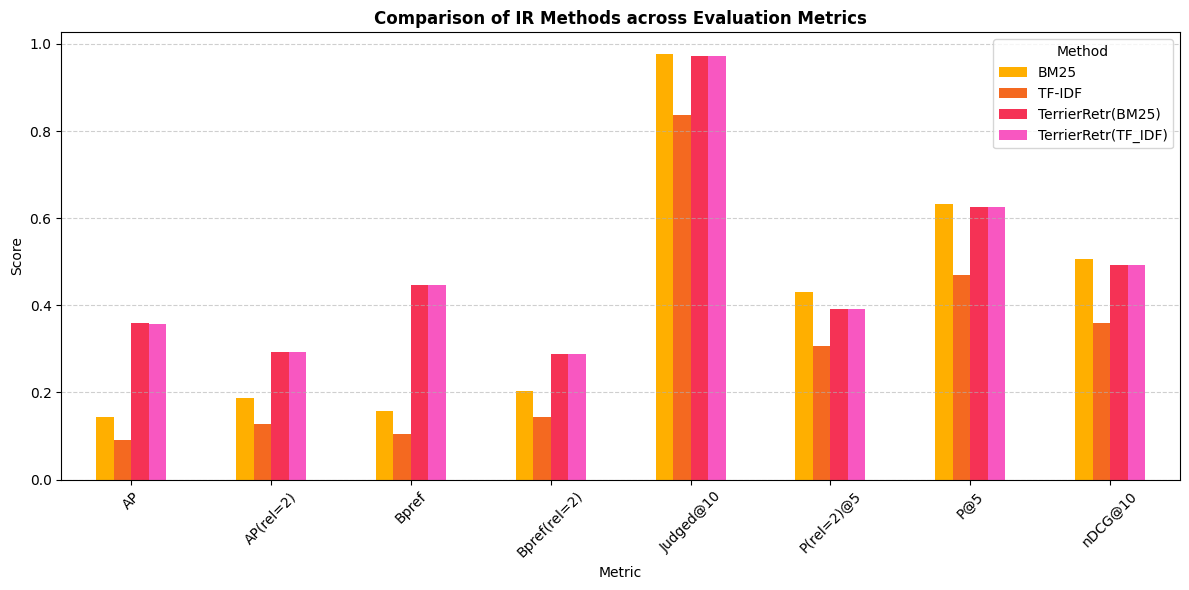

In [ ]:
color = ["#FFAF00", "#F46920", "#F53255", "#F857C1"]
results_comparison.plot(kind='bar', figsize=(12, 6), color=color)

plt.xlabel('Metric', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.title('Comparison of IR Methods across Evaluation Metrics', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)
plt.legend(title="Method")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### 6.2.1 **Observations**

In this project, we successfully designed and implemented a complete **on-disk Information Retrieval system** based on a compressed inverted index architecture. The use of the SPIMI algorithm allowed us to **efficiently index** a large-scale corpus while maintaining a **low memory footprint**, thanks to its single-pass chunking strategy and merging phase.

Our implementation allows fast access and decompression during query evaluation, resulting in a **negligible loss of performance** with respect to an on-RAM system.

The comparison with PyTerrier highlights an important trade-off. While our custom BM25 implementation underperforms PyTerrier in global ranking quality (as shown by AP and Bpref metrics), it slightly **outperforms it in early precision and top-ranked relevance metrics** (e.g., P@5 and nDCG@10). This indicates that our index is effective in surfacing highly relevant documents in the top positions, which is crucial for user satisfaction in real-world IR systems.